Modelo 2 Utilizando min max y Cosine similarity.

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
spotify_data = pd.read_csv("../PROYECTO2 K MEANS/spotify-dataset/data/data.csv")

In [4]:
spotify_features_df = spotify_data
genre_OHE = pd.get_dummies(spotify_features_df.genre)
key_OHE = pd.get_dummies(spotify_features_df.key)

Como podemos ver que las columnas numéricas tienen diferentes rangos, realizaremos una normalización máxima-mínima para cambiar los valores de las columnas numéricas en el conjunto de datos a una escala estándar.

Es el enfoque de normalización más común donde el valor mínimo en la columna de características se transforma en 0 y el valor máximo en la columna de características se transforma en 1.

In [5]:
scaled_features = MinMaxScaler().fit_transform([
  spotify_features_df['acousticness'].values,
  spotify_features_df['danceability'].values,
  spotify_features_df['duration_ms'].values,
  spotify_features_df['energy'].values,
  spotify_features_df['instrumentalness'].values,
  spotify_features_df['liveness'].values,
  spotify_features_df['loudness'].values,
  spotify_features_df['speechiness'].values,
  spotify_features_df['tempo'].values,
  spotify_features_df['valence'].values,
  ])

In [6]:
#Almacenar los vectores de columna transformados en nuestro marco de datos
spotify_features_df[['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']] = scaled_features.T

Eliminamos las características que no se consideran para determinar la similitud y las características categóricas que ya están convertidas en vectores OHE.

In [7]:
spotify_features_df = spotify_features_df.drop('genre',axis = 1)
spotify_features_df = spotify_features_df.drop('artist_name', axis = 1)
spotify_features_df = spotify_features_df.drop('track_name', axis = 1)
spotify_features_df = spotify_features_df.drop('popularity',axis = 1)
spotify_features_df = spotify_features_df.drop('key', axis = 1)
spotify_features_df = spotify_features_df.drop('mode', axis = 1)
spotify_features_df = spotify_features_df.drop('time_signature', axis = 1)

In [8]:
# Append a las columnas OHE de las características categóricas
spotify_features_df = spotify_features_df.join(genre_OHE)
spotify_features_df = spotify_features_df.join(key_OHE)

Al igual que en el modelo de k means utilizamos la api de spotify web

In [39]:
client_id = "9c56eda59b544c55a63028477b5b7e18"
client_secret= "6fcc6b2dc613464a92c60ed4fc81cb52"

ESTAS CLAVES SON DE LA CUENTA PERSONAL DEL AUTOR

Guardamos los detalles de la playlist en un diccionario de python

In [61]:
scope = 'user-library-read'
token = util.prompt_for_user_token(
    scope, 
    client_id= client_id, 
    client_secret=client_secret, 
    redirect_uri='http://localhost:8881/callback'
  )
sp = spotipy.Spotify(auth=token)
playlist_dic = {}
playlist_cover_art = {}

for i in sp.current_user_playlists()['items']:
    playlist_dic[i['name']] = i['uri'].split(':')[2]
    playlist_cover_art[i['uri'].split(':')[2]] = i['images'][0]['url']

print(playlist_dic)

{'Daphne': '2h6g4MNyMwIyl5legG7q33', 'Lone': '0mYTzihgs31hj0yqomfNYN', 'Estudiar': '3fZDKXsEHPqa289vLqItdb', 'Mis pistas de Shazam': '0VDyTRhKn3Gr2zdnvbiFHl'}


El siguiente método crea una df para nuestra playlist utilizando el conjunto de datos de características de canciones de Spotify.


In [62]:
def generate_playlist_df(playlist_name, playlist_dic, spotify_data):
    
    playlist = pd.DataFrame()

    for i, j in enumerate(sp.playlist(playlist_dic[playlist_name])['tracks']['items']):
        playlist.loc[i, 'artist'] = j['track']['artists'][0]['name']
        playlist.loc[i, 'track_name'] = j['track']['name']
        playlist.loc[i, 'track_id'] = j['track']['id']
        playlist.loc[i, 'url'] = j['track']['album']['images'][1]['url']
        playlist.loc[i, 'date_added'] = j['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['track_id'].isin(spotify_data['track_id'].values)].sort_values('date_added',ascending = False)

    return playlist
playlist_df = generate_playlist_df('Lone', playlist_dic, spotify_data) 

In [63]:
playlist_df.head()

,artist,track_name,track_id,url,date_added
17,Peter Manos,In My Head,1tT55K6VEyO6XFDxK4lDQe,https://i.scdn.co/image/ab67616d00001e023c0c1f...,2020-09-18 13:57:12+00:00
15,XXXTENTACION,changes,7AFASza1mXqntmGtbxXprO,https://i.scdn.co/image/ab67616d00001e02806c16...,2020-09-18 13:53:57+00:00
14,Alec Benjamin,Let Me Down Slowly,2qxmye6gAegTMjLKEBoR3d,https://i.scdn.co/image/ab67616d00001e02459d67...,2020-09-18 13:52:49+00:00
13,Lil Yung Pharaoh,"I Hate You, But I Love You",4upK9OgMepvBFEGD8CDE9A,https://i.scdn.co/image/ab67616d00001e02186fb7...,2020-09-18 13:52:35+00:00
12,Ivan B,Back to You,3hX2VFUZi2W5slqkP7hAvw,https://i.scdn.co/image/ab67616d00001e02a6d9a0...,2020-09-18 13:51:10+00:00


In [64]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_cover_art(playlist_df):
    temp = playlist_df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))) , facecolor='#8cfc03')
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        s='' 
        plt.xlabel(s.join(playlist_df['track_name'].values[i].split(' ')[:4]), fontsize = 10, fontweight='bold')
        plt.tight_layout(h_pad=0.8, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

Para realizar la cosine similarity entre nuestra playlist y las canciones que no están presentes en nuestra playlist, se resume nuestra playlist en un vector. Este vector representará nuestra playlist en el espacio de caracteristicas, y podremos encontrar canciones similares a las canciones en nuestra playlist.

El siguiente metodo devuelve nuestra playlist como un solo vector y todas las canciones que no están presentes en nuestra lista de reproducción en una df.

In [65]:
def generate_playlist_vector(spotify_features, playlist_df, weight_factor):
    
    spotify_features_playlist = spotify_features[spotify_features['track_id'].isin(playlist_df['track_id'].values)]
    spotify_features_playlist = spotify_features_playlist.merge(playlist_df[['track_id','date_added']], on = 'track_id', how = 'inner')
    
    spotify_features_nonplaylist = spotify_features[~spotify_features['track_id'].isin(playlist_df['track_id'].values)]
    
    playlist_feature_set = spotify_features_playlist.sort_values('date_added',ascending=False)
    
    
    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'days_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days)
        
    
    playlist_feature_set['weight'] = playlist_feature_set['days_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-3].mul(playlist_feature_set_weighted.weight.astype(int),0))   
    
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-3]
    

    
    return playlist_feature_set_weighted_final.sum(axis = 0), spotify_features_nonplaylist

In [66]:
playlist_vector, nonplaylist_df = generate_playlist_vector(spotify_features_df, playlist_df, 1.2)
print(playlist_vector.shape)
print(nonplaylist_df.head())

(50,)
                 track_id  acousticness  danceability  duration_ms    energy  \
0  0BRjO6ga9RKCKjfDqeFgWV      0.000025      0.000022          1.0  0.000028   
1  0BjC1NfoEOOusryehmNudP      0.000042      0.000045          1.0  0.000046   
2  0CoSDzoNIKCRs124s9uTVy      0.000087      0.000085          1.0  0.000082   
3  0Gc6TVm52BwZD07Ki6tIvf      0.000084      0.000081          1.0  0.000082   
4  0IuslXpMROHdEPvSl1fTQK      0.000267      0.000260          1.0  0.000259   

   instrumentalness  liveness  loudness  speechiness     tempo  ...  B  C  C#  \
0          0.000018  0.000022       0.0     0.000019  0.001699  ...  0  0   1   
1          0.000040  0.000042       0.0     0.000041  0.001307  ...  0  0   0   
2          0.000082  0.000082       0.0     0.000082  0.000666  ...  0  1   0   
3          0.000080  0.000081       0.0     0.000080  0.001207  ...  0  0   1   
4          0.000257  0.000258       0.0     0.000256  0.001957  ...  0  0   0   

   D  D#  E  F  F#  G  G# 

Se utiliza cosine similarity como una métrica de similitud para determinar las canciones que son muy similares a nuestra playlist.

Realizaremos la cosine similarity entre nuestro vector de playlist y las canciones que no están presentes en playlist.

Luego, realizaremos la cosine similarity utilizando una biblioteca basada en Python, Scikit, y almacenaremos los valores de cosine similarity en una columna separada.

A continuación, invertiremos la ordenación del df en función de la columna de cosine similarity. Finalmente, generaremos las 15 mejores recomendaciones de canciones como nuestra playlist recomendada.

In [67]:
def generate_recommendation(spotify_data, playlist_vector, nonplaylist_df):

    non_playlist = spotify_data[spotify_data['track_id'].isin(nonplaylist_df['track_id'].values)]
    non_playlist['sim'] = cosine_similarity(nonplaylist_df.drop(['track_id'], axis = 1).values, playlist_vector.drop(labels = 'track_id').values.reshape(1, -1))[:,0]
    non_playlist_top15 = non_playlist.sort_values('sim',ascending = False).head(15)
    non_playlist_top15['url'] = non_playlist_top15['track_id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return  non_playlist_top15

In [68]:
top15 = generate_recommendation(spotify_data, playlist_vector, nonplaylist_df)  
top15.head(15)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_16872\43927750.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_playlist['sim'] = cosine_similarity(nonplaylist_df.drop(['track_id'], axis = 1).values, playlist_vector.drop(labels = 'track_id').values.reshape(1, -1))[:,0]


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,sim,url
87125,Rap,XXXTENTACION,Carry On,2yZax79pOrYuyIFVW2cZY2,80,0.000109,0.000109,1.0,0.000105,0.000103,D#,0.000105,0.0,Minor,0.000107,0.001243,4/4,0.000106,0.828325,https://i.scdn.co/image/ab67616d00001e02203c89...
117800,Rap,Shoreline Mafia,Traplantic,6ymdTUcJygnxQcRDXDRG5F,57,0.000083,0.000090,1.0,0.000087,0.000083,C#,0.000084,0.0,Major,0.000085,0.001310,4/4,0.000083,0.828325,https://i.scdn.co/image/ab67616d00001e02125adb...
122157,Rap,Lil Tracy,Heart,3FwjVGj09AuW9cplShwmFl,55,0.000101,0.000105,1.0,0.000103,0.000101,C#,0.000101,0.0,Minor,0.000101,0.001209,4/4,0.000102,0.828325,https://i.scdn.co/image/ab67616d00001e02735890...
119423,Rap,"Tyler, The Creator",WOLF,2JZpS2sOdJy37oBpn1GuPW,53,0.000108,0.000109,1.0,0.000108,0.000105,C#,0.000109,0.0,Minor,0.000106,0.001370,4/4,0.000108,0.828325,https://i.scdn.co/image/ab67616d00001e026be680...
117802,Rap,J. Cole,Mo Money (Interlude),3Iz0A1nuTjiLvXQaBxjWzn,57,0.000108,0.000106,1.0,0.000108,0.000098,C#,0.000100,0.0,Minor,0.000103,0.001191,4/4,0.000104,0.828325,https://i.scdn.co/image/ab67616d00001e025bed71...
118464,Rap,frumhere,she only likes me when i'm drunk,3VDags0na6nY1gBjCt2e8v,60,0.000124,0.000125,1.0,0.000124,0.000127,C#,0.000121,0.0,Minor,0.000121,0.001391,4/4,0.000122,0.828325,https://i.scdn.co/image/ab67616d00001e02b5ddd9...
120299,Rap,Moneybagg Yo,Exactly,08LjGHJ3xsccMyCJdztsns,52,0.000071,0.000077,1.0,0.000076,0.000071,C#,0.000072,0.0,Major,0.000073,0.001246,4/4,0.000075,0.828325,https://i.scdn.co/image/ab67616d00001e02138506...
120712,Rap,Ski Mask The Slump God,Death Is Long,5uTdUCENzIlVXTfse6MLGX,53,0.000096,0.000100,1.0,0.000098,0.000093,C#,0.000096,0.0,Major,0.000096,0.001180,4/4,0.000098,0.828325,https://i.scdn.co/image/ab67616d00001e021491f5...
120737,Rap,BEXEY,Stay Alive (feat. Fat Nick),0NtYGyNUHAvdjI4nlYGRMw,58,0.000074,0.000078,1.0,0.000079,0.000073,C#,0.000074,0.0,Major,0.000074,0.001219,4/4,0.000077,0.828325,https://i.scdn.co/image/ab67616d00001e02926c6d...
122058,Rap,Big Sean,Same Time Pt. 1,7yoe9vbbzakNAXwb1UaWLS,52,0.000087,0.000085,1.0,0.000085,0.000079,C#,0.000083,0.0,Major,0.000083,0.001385,4/4,0.000087,0.828325,https://i.scdn.co/image/ab67616d00001e02e57235...


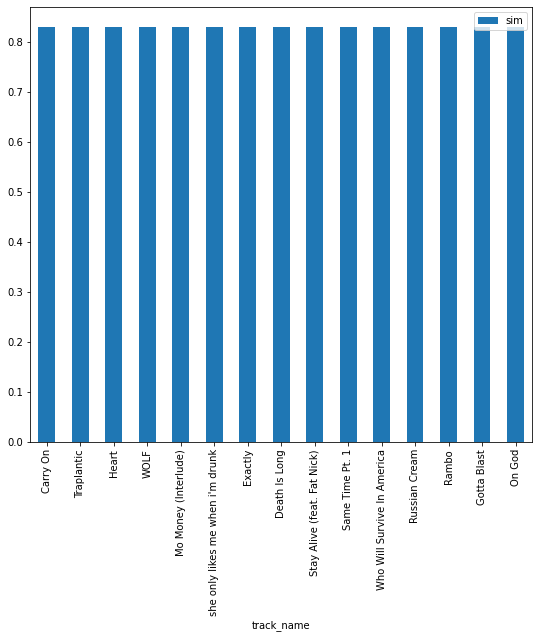

In [72]:
top15.plot(x="track_name", y=["sim"], kind="bar", figsize=(9, 8))
plt.show()